In [89]:
import pandas as pd
import numpy as np
import boto3
import sagemaker
import os 
import torch

In [67]:
# helper function
def make_csv(x, filename, data_dir, append=False, header=False, index=False):
    '''Merges features and labels and converts them into one csv file with labels in the first column.
       :param x: Data features
       :param file_name: Name of csv file, ex. 'train.csv'
       :param data_dir: The directory where files will be saved
       '''
    
    # create dir if nonexistent
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    # make sure its a df
    x = pd.DataFrame(x)
    
    # export to csv
    if not append:
        x.to_csv(os.path.join(data_dir, filename), 
                                     header=header, 
                                     index=index)
    else:
        x.to_csv(os.path.join(data_dir, filename),
                                     mode = 'a',
                                     header=header, 
                                     index=index)        
    
    # nothing is returned, but a print statement indicates that the function has run
    print('Path created: '+str(data_dir)+'/'+str(filename))

In [115]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

print("SESSION\n>>>>---- {}\nROLE\n>>>>---- {}\nBUCKET\n>>>>---- {}\n".format(sagemaker_session, role, bucket))
print("Pytorch version", torch.__version__)

SESSION
>>>>---- <sagemaker.session.Session object at 0x7f3d7f73a160>
ROLE
>>>>---- arn:aws:iam::566985399728:role/service-role/AmazonSageMaker-ExecutionRole-20200729T090929
BUCKET
>>>>---- sagemaker-us-east-1-566985399728

Pytorch version 1.4.0


In [81]:
# should be the name of directory created to save features data
data_dir = "./data/final"

print("In dir {} found:".format(data_dir))
print(os.listdir(data_dir))

# set prefix, a descriptive name for a directory  
prefix = 'esg'

# upload to S3
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
print(input_data)

In dir ./data/final found:
['train.csv', 'test.csv']
s3://sagemaker-us-east-1-566985399728/esg


In [82]:
# check that upload was correct
# iterate through S3 objects and print contents
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
     print(obj.key)
        
# confirm that data is in S3 bucket
empty_check = []
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    print(obj.key)

assert len(empty_check) !=0, 'S3 bucket is empty.'
print('Test passed!')

esg/pytorch-training-2020-08-05-06-59-28-877/debug-output/collections/000000000/worker_0_collections.json
esg/pytorch-training-2020-08-05-06-59-28-877/debug-output/events/000000000000/000000000000_worker_0.tfevents
esg/test.csv
esg/train.csv
pytorch-training-2020-08-05-06-12-52-545/source/sourcedir.tar.gz
pytorch-training-2020-08-05-06-21-55-500/source/sourcedir.tar.gz
pytorch-training-2020-08-05-06-36-50-637/source/sourcedir.tar.gz
pytorch-training-2020-08-05-06-42-59-724/source/sourcedir.tar.gz
pytorch-training-2020-08-05-06-59-28-877/source/sourcedir.tar.gz
pytorch-training-2020-08-05-07-20-39-791/source/sourcedir.tar.gz
esg/pytorch-training-2020-08-05-06-59-28-877/debug-output/collections/000000000/worker_0_collections.json
esg/pytorch-training-2020-08-05-06-59-28-877/debug-output/events/000000000000/000000000000_worker_0.tfevents
esg/test.csv
esg/train.csv
pytorch-training-2020-08-05-06-12-52-545/source/sourcedir.tar.gz
pytorch-training-2020-08-05-06-21-55-500/source/sourcedir.tar

# Pytorch model
## Load training script

In [83]:
# directory can be changed to: source_sklearn or source_pytorch
!pygmentize source_pytorch/train.py

import argparse
import json
import os
import pandas as pd
import torch
import torch.optim as optim
import torch.utils.data
import torch.nn as nn

# imports the model in model.py by name
from model import BinaryClassifier

def model_fn(model_dir):
    """Load the PyTorch model from the `model_dir` directory."""
    print("Loading model.")

    # First, load the parameters used to create the model.
    model_info = {}
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    with open(model_info_path, 'rb') as f:
        model_info = torch.load(f)

    print("model_info: {}".format(model_info))

    # Determine the device and construct the model.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BinaryClassifier(model_info['input_features'], model_info['hidden_dim'], model_info['output_dim'])

    # Load the stored model parameters.
    model_path = os.path.join(model_dir, 'model.pth')
    with open(model_path, 'rb') as f:
        model.load_

---
# Create an Estimator

When a custom model is constructed in SageMaker, an entry point must be specified. This is the Python file which will be executed when the model is trained; the `train.py` function you specified above. To run a custom training script in SageMaker, construct an estimator, and fill in the appropriate constructor arguments:

* **entry_point**: The path to the Python script SageMaker runs for training and prediction.
* **source_dir**: The path to the training script directory `source_sklearn` OR `source_pytorch`.
* **entry_point**: The path to the Python script SageMaker runs for training and prediction.
* **source_dir**: The path to the training script directory `train_sklearn` OR `train_pytorch`.
* **entry_point**: The path to the Python script SageMaker runs for training.
* **source_dir**: The path to the training script directory `train_sklearn` OR `train_pytorch`.
* **role**: Role ARN, which was specified, above.
* **train_instance_count**: The number of training instances (should be left at 1).
* **train_instance_type**: The type of SageMaker instance for training. Note: Because Scikit-learn does not natively support GPU training, Sagemaker Scikit-learn does not currently support training on GPU instance types.
* **sagemaker_session**: The session used to train on Sagemaker.
* **hyperparameters** (optional): A dictionary `{'name':value, ..}` passed to the train function as hyperparameters.


## Train Pytorch model

In [85]:
from sagemaker.pytorch import PyTorch # SM pytorch wrapper

# select instance
instance =  'ml.m4.xlarge' #'ml.c4.xlarge'

# specify output path in S3
output_path = 's3://{}/{}'.format(bucket, prefix)
print("S3 OUTPUT PATH:\n{}".format(output_path))

# instantiate a pytorch estimator
estimator = PyTorch(entry_point='train.py',
                   source_dir='source_pytorch', 
                   role=role,
                   framework_version='1.5.0', #latest version 
                   train_instance_count=1, 
                   train_instance_type=instance,
                   output_path=output_path,
                   sagemaker_session=sagemaker_session, 
                   hyperparameters={
                       'input_features': 145, #try different values
                       'hidden_dim': 512,
                       'output_dim': 1,
                       'epochs': 40
                   })

# %%time

# Train your estimator on S3 training data
estimator.fit({'train': input_data})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


S3 OUTPUT PATH:
s3://sagemaker-us-east-1-566985399728/esg
2020-08-05 07:51:51 Starting - Starting the training job...
2020-08-05 07:51:53 Starting - Launching requested ML instances.........
2020-08-05 07:53:34 Starting - Preparing the instances for training...
2020-08-05 07:54:20 Downloading - Downloading input data......
2020-08-05 07:55:04 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-08-05 07:55:30,867 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-08-05 07:55:30,870 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-08-05 07:55:30,883 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-08-05 07:55:30,887 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-08-05 07:55:31,150 sagemaker-containers INFO     Module default_user_mo


2020-08-05 07:55:48 Uploading - Uploading generated training model
2020-08-05 07:55:48 Completed - Training job completed
2020-08-05 07:55:40,425 sagemaker-containers INFO     Reporting training SUCCESS
Training seconds: 88
Billable seconds: 88


## Deploy Pytorch model

In [86]:
%%time

from sagemaker.pytorch import PyTorchModel

# Create a model from previously trained estimator
# and point to the prediction script
model = PyTorchModel(model_data=estimator.model_data, 
                    role=role,
                    framework_version='1.5.0',
                    entry_point='predict.py',
                    source_dir='source_pytorch')


# deploy model to create a predictor
predictor = model.deploy(initial_instance_count=1,
                        instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-------------------!CPU times: user 511 ms, sys: 54.1 ms, total: 565 ms
Wall time: 9min 33s


## Predict on test data

In [87]:
import os

# read in test data, assuming it is stored locally
test_data = pd.read_csv(os.path.join(data_dir, "test.csv"), header=None, names=None)

# labels are in the first column
test_y = test_data.iloc[:,0]
test_x = test_data.iloc[:,1:]

## Evaluate 

In [143]:
# code to evaluate the endpoint on test data
# returns a variety of model metrics
import numpy as np

def evaluate(predictor, test_features, test_labels, preds=None, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    
    # rounding and squeezing array
    if preds is None:
        test_preds = np.squeeze(np.round(predictor.predict(test_features)))
    else:
        test_preds = np.squeeze(np.round(preds))
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    # print metrics
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actuals'], colnames=['predictions']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print()
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}

In [91]:
# retrieve prediction for test set
test_preds = np.squeeze(np.round(predictor.predict(test_x)))
df_test_preds = pd.DataFrame(test_preds)

make_csv(df_test_preds, 'test_preds_pytorch.csv', 'data')

# get metrics for custom predictor
metrics = evaluate(predictor, test_x, test_y, verbose=True)
metrics

     0
0  1.0
1  1.0
2  0.0
3  0.0
4  1.0
Path created: data/test_preds_pytorch.csv


## Delete endpoint

In [95]:
# Accepts a predictor endpoint as input
# And deletes the endpoint by name
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
            print('Deleted {}'.format(predictor.endpoint))
        except:
            print('Already deleted: {}'.format(predictor.endpoint))

# delete the predictor endpoint 
delete_endpoint(predictor)

Deleted pytorch-inference-2020-08-05-07-56-25-972


# SKlearn model
## Load training script

In [100]:
# directory can be changed to: source_sklearn or source_pytorch
!pygmentize source_sklearn/train.py

from __future__ import print_function

import argparse
import os
import pandas as pd

from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression



# Provided model load function
def model_fn(model_dir):
    """Load model from the model_dir. This is the same model that is saved
    in the main if statement.
    """
    print("Loading model.")
    
    # load using joblib
    model = joblib.load(os.path.join(model_dir, "model.joblib"))
    print("Done loading model.")
    
    return model

if __name__ == '__main__':
    
    # All of the model parameters and training parameters are sent as arguments
    # when this script is executed, during a training job
    
    # Here we set up an argument parser to easily access the parameters
    parser = argparse.ArgumentParser()

    # SageMaker parameters, like the directories for training data and saving models; set automatically
    # Do not need to change
    parser.add_argument('--output-data-dir', type=str, d

In [108]:
from sagemaker.sklearn.estimator import SKLearn

sklearn = SKLearn(
    entry_point="train.py",
    source_dir="source_sklearn",
    train_instance_type="ml.c4.xlarge",
    framework_version='0.23-1',
    role=role,
    sagemaker_session=sagemaker_session)

# Train your estimator on S3 training data
sklearn.fit({'train': input_data})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-08-05 08:56:08 Starting - Starting the training job...
2020-08-05 08:56:11 Starting - Launching requested ML instances.........
2020-08-05 08:57:54 Starting - Preparing the instances for training......
2020-08-05 08:58:47 Downloading - Downloading input data...
2020-08-05 08:59:29 Training - Downloading the training image...
2020-08-05 09:00:08 Uploading - Uploading generated training model
2020-08-05 09:00:08 Completed - Training job completed
2020-08-05 08:59:55,636 sagemaker-training-toolkit INFO     Imported framework sagemaker_sklearn_container.training
2020-08-05 08:59:55,637 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-08-05 08:59:55,647 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-08-05 08:59:55,977 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-08-05 08:59:57,398 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-08-

## Deploy SKLearn model

In [109]:
%%time
# deploy model
sk_predictor = sklearn.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!CPU times: user 334 ms, sys: 16.5 ms, total: 350 ms
Wall time: 8min 32s


## Evaluate SKLearn model

In [111]:
# retrieve prediction for test set
test_preds = np.squeeze(np.round(sk_predictor.predict(test_x)))
df_test_preds = pd.DataFrame(test_preds)

make_csv(df_test_preds, 'test_preds_sklearn.csv', 'data')

# get metrics for custom predictor
metrics = evaluate(sk_predictor, test_x, test_y, verbose=True)
metrics

Path created: data/test_preds_sklearn.csv
predictions   0   1
actuals            
0             9  21
1            11  20

Recall:     0.645
Precision:  0.488
Accuracy:   0.475



{'TP': 20,
 'FP': 21,
 'FN': 11,
 'TN': 9,
 'Precision': 0.4878048780487805,
 'Recall': 0.6451612903225806,
 'Accuracy': 0.47540983606557374}

## Delete endpoint and S3 bucket

In [112]:
# delete the predictor endpoint 
delete_endpoint(sk_predictor)

Deleted sagemaker-scikit-learn-2020-08-05-08-56-08-381


In [113]:
# Delete bucket
bucket_to_delete = boto3.resource('s3').Bucket(bucket)
bucket_to_delete.objects.all().delete()

[{'ResponseMetadata': {'RequestId': '81B36A3C7B247590',
   'HostId': 'VAC5VkZEwQvM8TFjVw+1uljyfKWfPH5OA23NpKZn1xKBqoIrm9qzlwehkLqDHYMAuJvtkPYpmbM=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': 'VAC5VkZEwQvM8TFjVw+1uljyfKWfPH5OA23NpKZn1xKBqoIrm9qzlwehkLqDHYMAuJvtkPYpmbM=',
    'x-amz-request-id': '81B36A3C7B247590',
    'date': 'Wed, 05 Aug 2020 09:14:53 GMT',
    'connection': 'close',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'esg/pytorch-training-2020-08-05-08-22-10-287/debug-output/index/000000000/000000000000_worker_0.json'},
   {'Key': 'esg/pytorch-training-2020-08-05-07-51-51-037/debug-output/index/000000000/000000000000_worker_0.json'},
   {'Key': 'esg/pytorch-training-2020-08-05-08-22-10-287/debug-output/events/000000000500/000000000500_worker_0.tfevents'},
   {'Key': 'esg/pytorch-training-2020-08-05-06-59-28-877/debug-output/events/000000000000/000000000000_

# Compare models

In [174]:
#plots
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("talk")

In [186]:
data_dir = './data/'

# load predictions
preds_pytorch = pd.read_csv(data_dir+'test_preds_pytorch.csv', header=None)
preds_sklearn = pd.read_csv(data_dir+'test_preds_sklearn.csv', header=None)

metrics_sklearn = evaluate(None, test_x, test_y, preds=preds_sklearn, verbose=False)
metrics_pytorch = evaluate(None, test_x, test_y, preds=preds_pytorch, verbose=False)

df_comparison = pd.DataFrame({'sklearn': metrics_sklearn, 'pytorch':metrics_pytorch})\
        .reset_index()\
        .melt(id_vars='index', value_vars=['sklearn', 'pytorch'])

In [187]:
df_comparison

,index,variable,value
0,TP,sklearn,20.000000
1,FP,sklearn,21.000000
2,FN,sklearn,11.000000
3,TN,sklearn,9.000000
4,Precision,sklearn,0.487805
5,Recall,sklearn,0.645161
6,Accuracy,sklearn,0.475410
7,TP,pytorch,24.000000
8,FP,pytorch,20.000000
9,FN,pytorch,7.000000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


        index             variable     value
4   Precision  Logistic Classifier  0.487805
5      Recall  Logistic Classifier  0.645161
6    Accuracy  Logistic Classifier  0.475410
11  Precision       Neural Network  0.545455
12     Recall       Neural Network  0.774194
13   Accuracy       Neural Network  0.557377


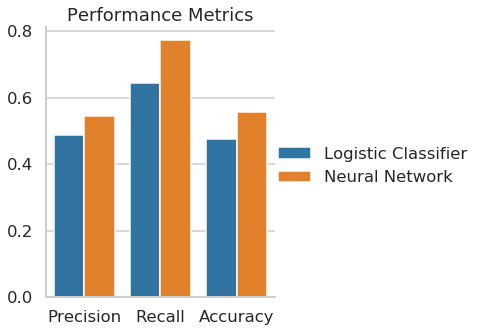

In [226]:
df_plot = df_comparison[df_comparison['index'].isin(['Precision', 'Recall', 'Accuracy'])]
df_plot.replace({'sklearn': 'Logistic Classifier', 'pytorch': 'Neural Network'}, inplace=True)
print(df_plot)
g = sns.catplot(x="index", y="value", hue='variable', data=df_plot, kind="bar", legend_out = True)

g.set(title='Performance Metrics')

g._legend.set_title('')
g.set(xlabel=None, ylabel=None)
plt.show()